# Projet MOGPL: la balade du robot

### Sportich Benjamin, de Bézenac Emmanuel

In [1]:
%matplotlib inline
import projet_mogpl as p

# Introduction
>  Un robot est utilisé dans le dépôt d'un grand magasin pour le transport d'objets. On s'intéresse à la minimisation du temps de transport du robot. Le robot peut se déplacer uniquement sur des lignes droites (rails). Tous les rails forment une grille rectangulaire. La distance entre deux rails voisins est d'un mètre. Le dépôt est un rectangle de $N \times M$ mètres et il est entièrement couvert par la grille. Le robot a une forme circulaire de diamètre égale à 1.6 mètre. Le rail passe par le centre du robot. Le robot se dirige seulement en quatre directions : nord, sud, est, ouest. Les rails suivent les directions sud-nord et ouest-est. Le robot se déplace uniquement vers la direction vers laquelle il fait face. La direction vers laquelle le robot fait face peut-être changée au croisement de rails. Initialement, le robot se trouve à un croisement de rails. Des obstacles dans le dépôt sont formés par des pièces de taille 1 mètre x 1 mètre posées sur le sol. Chaque obstacle est posé sur un carré de taille 1 mètre x 1 mètre formé par les rails. Le mouvement du robot est contrôlé par deux commandes _AVANCE_ et _TOURNE_. La commande _AVANCE_ a un paramètre entier $n \in \{1, 2, 3\}$. Quand il reçoit cette commande, le robot avance de n mètres dans la direction vers laquelle il fait face. La commande TOURNE a comme argument gauche ou droite. Quand il reçoit cette commande, le robot change son orientation de 90° degrés dans la direction indiquée par le paramètre. L'exécution de chaque commande dure une seconde. On souhaite écrire un programme qui détermine le temps minimum pour le déplacement du robot d'un point de départ donné à un point d'arrivée donné.



Afin de résoudre ce problème,nous avons décidé de le formaliser en utilisant le langage Python ainsi que la librairie de graphes NetworkX. Nous verrons comment formaliser le problème de la balade du robot, puis une évaluation de la complexité des algorithmes utilisés ainsi que des tests empiriques de l'évolution du temps de calcul en fonction de différents paramètres,et puis pour finir, notre implémentation de l'interface de visualisation de la solution au problème initial. 

# Formalisation du problème

Intéressons nous d'abord a une seule instance du problème de la balade du robot.

Nous avons vu que $M \times N$ correspond à la taille de notre grille.

- Soit $A$ une matrice de taille $M \times N$ où $\forall i$, $i\in \{0,...,M-1\}$, $\forall j$, $j\in \{0,...,N-1\}$, et $A_{i,j} \in \{0,1\}$. Si $A_i,_j=1$, il y a un obstacle sur la case $(i,j)$, sinon, la case est libre. 


- Soit $X$ l'ensemble des points de la grille, c'est-à-dire l'ensemble des points $x_{i,j} \in X$ tel que $i \in \{0,...,M\}$, et $j \in \{0,...,N\}$. La cardinalité $|X|$ de $X$ est égale à $(M+1)(N+1)$.


- Soit $L$ l'ensemble des points accessibles pour le robot. Nous avons donc que $L \subset X$. Si $x_{i,j} \in X$, avec $i \in \{0,...,M\}$, $j \in \{0,...,N\}$, alors on a comme conséquence directe que , $A_{i,j}=0$, $A_{i-1,j}=0$,$A_{i-1,j}=0$, et $A_{i-1,j-1}=0$. Cela correspond effectivement à notre intuition car le robot ne peut se trouver à un point adjacent à un obstacle. 


- Soit $O$ l'ensemble des points non atteignables par le robot, on peut le définir comme l'ensemble complémentaire de $P$ par rapport à $X$, c'est-à-dire $L \oplus O=X$ ($X \cap O = \emptyset$ et $L \cup O = X$).   Si $x_{i,j} \in O$, alors on a comme conséquence directe que $A_{i,j}=1$, ou que $A_{i-1,j}=1$, ou que $A_{i,j-1}=1$, ou que $A_{i-1,j-1}=1$. 




- Nous avons également un point de départ $x_{start}$, et une point d'arrivée $x_{end}$, avec la contrainte que $x_{start} \in L$, et $x_{end} \in L$. Si un point $x_{i,j} \in L$, sa direction associée est dénotée $d_{i,j}$, avec $d_{i,j} \in \{nord, sud, est, ouest\}$. 


- Une position $p_{i,j,d}$ est donc définie par un couple $(x_{i,j},d_{i,j})$. Soit $P$ l'ensemble des positions possibles. La cardinalité $|P|$ de l'ensemble $P$ peut être calculée, et correspond à: $|P|= 4|L|$, puisqu'il y a 4 directions possibles par point. Comme $L=X \backslash O$, $|L|=|X|-|O|$, et donc $|L| \le |X|$, et $|L| \le (M+1)(N+1)$ puisque $|X|=(M+1)(N+1)$, nous avons donc que $|P| \le 4(M+1)(N+1)$.


- Soit $C$ une séquence ordonnée de positions $p_k \in P$, avec $C=\{p_1,\dots,p_{n+1}\}$. Ceci correspond au parcours que prend le robot dans la grille, $n$ étant la durée (en secondes) de ce parcours. Nous avons que $C \subset P$. Soit $|C|$ la cardinalité de la séquence: nous pouvons donc observer que $n=|C|-1$ secondes. Pour que $C$ puisse être un parcours valable il est nécéssaire que le premier élément $p_1$ de $C$ corresponde à $(x_{start},s_{dir})$, que le dernier élément $p_n+1=(e_{pos},e_{dir})$, avec $e_{dir}$ quelconque. Il est également nécéssaire que pour deux éléments contigus $p_k$ et $p_{k+1}$ de $C$, que $p_{k+1}$ soit *directement accessible* depuis $p_k$.


- Soit $a=(i,j,d_{i,j})$ et $b=(k,l,d_{k,l})$ deux points de $P$. On dit que $b$ est *directement accessible* depuis $a$ si et seulement si:
   * $i=k$ et $|j-l| \le 3$ et $d_{i,j}=d_{k,l}$ et que tout point entre $a$ et $b$ appartienne à $P$. Ceci correspond au cas où on se déplace de 1, 2, ou 3 cases d'une colonne à une autre tout en restant sur la même ligne , ou
   * $|i-k| \le 3$ et $j=l$ et $d_{i,j}=d_{k,l}$ et que tout point entre $a$ et $b$ appartienne à $P$. Ceci correspond au cas où on se déplace de 1, 2, ou 3 cases d'une ligne à une autre tout en restant sur la même colonne, ou
   * $i=k$ et $j=l$ et $|d_{i,j}=d_{k,l}| \le 1$, c'est-à-dire par exemple si, $d_{i,j}=nord$, $d_{k,l}$ peut uniquement prendre ses valeurs parmi $\{est,ouest\}$. Ceci correspond au cas où on effectue une rotation de 90 degrés vers la gauche ou vers la droite.

**Problème de la balade du robot:**

**Entrée:**
Deux entiers M et N, une matrice A de taille $M \times N$, un ensemble d'obstacles O, une position de départ $p_{start} \in P$, et une position d'arrivée $p_{end} \in P$.


**Question:**
Quel est le parcours $C$ (si il existe) qui minimise la durée $n$ entre la position de départ et le point d'arrivée? Ou encore: que vaut $\displaystyle \min_{p_1,\dots p_{n+1}} C$, avec $p_i \in P$, et que valent $\{p_1,\dots p_{n+1}\}$ ?.


Afin de répondre à cette question, nous avons choisi de reformuler ce probème en utilisant un graphe orienté. 
Soit $G=(V,E)$ ce graphe orienté, avec $V$ ses noeuds et $E$ ses arcs. Pour tout élément $p_k $ de $P$, assignons un noeud analogue dans le graphe G. Pour tout élément $p_{k+1}$ directement accessible par $p_k$, assignons l'arc $(p_k,p_{k+1})$ étiqueté par la nature de son déplacement: ($a1$, $a2$, $a3$, $G$, ou $D$) .

Le problème devient alors le suivant:


**Problème reformulé de la balade du robot:**

**Entrée:**
Un graphe $G=(V,E)$, avec les noeuds et les arcs définis comme ci-dessus.


**Question:**
Quel est le chemin $C'$ (si il existe) qui minimise la durée $n$ entre la position de départ et le point d'arrivée? Si il existe, quelles sont les étiquettes des arcs de ce chemin?

Cette question est nettement plus simple que la première: une fois la génération des noeuds et des arcs du graphe G, il suffit d'executer un algorithme de plus court chemin. Nous utiliserons içi le parcours en largeur, vu qu'il n'y a pas de poids attribués aux arcs (tout arc peut être interprété par un déplacement de durée 1 seconde).

Voici un exemple de transformation de du problème initial au second.

[[0 0 0]
 [0 0 1]]


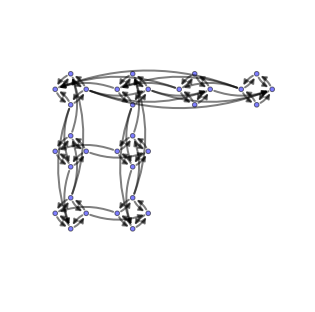

In [6]:
#Problème initial:
A=p.gen_rand_instance(2,3,1) #(M,N,nombre_dobstacles)
print A

#Problème reformulé:
G=p.gen_graph(A)
p.show_graph(G,figsize=(5,5))

# Evaluation de la complexité du problème



Rappelons $G= (V, E)$, notre graphe directionnel associé à un instance du problème. Nous avons donc par construction que $|V| = 4\big((M+1)(N+1)-|O|)$, donc $|V| \le 4(M+1)(N+1)$. De plus, $|E| \le 5|V|$, puisqu'il y a au plus 5 arcs crées à partir d'un noeud: les arcs étiquetés $D, G, a1, a2$, et $a3$. Donc $|E| \le 20(M+1)(N+1).$

- __Création du graphe__:
Un noeud est crée en $O(1)$, et un arc en $O(1)$ donc le graphe est crée en  $O(|E|+|V|)$, ou encore en $O(M.N)$.

Voici l'algorithme permettant de construire le graphe de G à partir de la matrice A.

In [3]:
def is_obstacle(i,j,A): #Teste si le point (i,j) appartient a O (O=X\P)
    M=A.shape[0]
    N=A.shape[1]
    #Cas Limites
    if(i==0): #Premiere ligne
        if(j==0): #Premiere case
            return A[0][0]
        if(j==N): #Derniere case
            return A[0][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[0][j] or A[0][j-1]       
    if(i==M): #Dernière ligne
        if(j==0): #Premiere case
            return A[M-1][0]
        if(j==N): #Derniere case
            return A[M-1][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[M-1][j-1] or A[M-1][j] 
    if(j==0): #Premiere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i][0] or A[i-1][0]       
    if(j==N): #Derniere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i-1][N-1] or A[i][N-1] 
    #Cas General
    if( i>=1 and j>=1 and i<M and j<N and A[i-1][j-1]==0 and A[i][j-1]==0 and A[i-1][j]==0 ):
        return A[i][j]
    return 1

def gen_graph(A):
    M=A.shape[0]
    N=A.shape[1]
    G=nx.DiGraph()
    for i in range(M+1):
        for j in range(N+1):
            if(is_obstacle(i,j,A)==False): # le point (i,j) n'appartient pas a O, il appartient donc a P.            
                #Creation des noeuds - un par direction = 4 par position                
                G.add_node((i,j,1),direct='nord')
                G.add_node((i,j,2),direct='est')
                G.add_node((i,j,3),direct='sud')
                G.add_node((i,j,4),direct='ouest')

                #Creation des arcs
                #Changement des directions               
                G.add_edge((i,j,1),(i,j,2),action='D')
                G.add_edge((i,j,1),(i,j,4),action='G')
                G.add_edge((i,j,2),(i,j,3),action='D')
                G.add_edge((i,j,3),(i,j,4),action='D')

                G.add_edge((i,j,2),(i,j,1),action='G')
                G.add_edge((i,j,4),(i,j,1),action='D')
                G.add_edge((i,j,3),(i,j,2),action='G')
                G.add_edge((i,j,4),(i,j,3),action='G')

                #Deplacement
                #Nord/Haut
                for k in [1,2,3]:
                    if(is_obstacle(i-k,j,A)==False): #(i,j) et (i-k,j) appartiennent a P, on peut donc creer l'arc
                        G.add_edge((i,j,1),(i-k,j,1),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                #Est/Droite
                for k in [1,2,3]:
                    if(is_obstacle(i,j+k,A)==False):
                        G.add_edge((i,j,2),(i,j+k,2),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j+k on ne creer pas d'arc en j+k+1
                
                #Sud/Bas
                for k in [1,2,3]:
                    if(is_obstacle(i+k,j,A)==False):
                        G.add_edge((i,j,3),(i+k,j,3),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i+k on ne creer pas d'arc en i-k+1
                
                #Ouest/Gauche
                for k in [1,2,3]:
                    if(is_obstacle(i,j-k,A)==False):
                        G.add_edge((i,j,4),(i,j-k,4),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j-k on ne creer pas d'arc en j-k-1
                        
    return G

- __Parcours en profondeur__:
Nous pouvons observer que le parcours en profondeur ne remet jamais un noeud dans la file. Les opérations de mise en file et de sortie de file prennent un temps $O(1)$, ou un temps de $O(|V|)$. Puisqu'on visite visite au plus tout les noeuds dans la liste d'adjacence, le temps total attribué à celui-ci est $O(|E|)$. La complexité du parcours en largeur est donc $O(|E|+|V|)$. Donc pour une instance donnée de taille $M.N$, nous avons donc que le parcours en profondeur du graphe associé est $O(M.N)$.

In [4]:
def BFS(start,end,G):
    dist={}
    for i in G.nodes():
        dist[i]=[np.inf,None] #dist: [distance a start, predecesseur]
    dist[start][0]=0
    q=[start]
    while(q):
        u=q.pop(0)
        for v in G.neighbors(u):
            if(np.isinf(dist[v][0])):
                dist[v][0]=dist[u][0]+1
                dist[v][1]=u
                q.append(v)
                #if(v[:-1]==end[:-1]): #on s'arrete lorsqu'on voit la fin
                #    return dist
    return dist

- __Backtracking__: Pour retrouver le plus court chemin, il faut partir du noeud d'arrivée et parcourir tout les noeuds précédés de G faudra parcourir tout les noeuds de $C'$ jusqu'à atteindre le noeud de départ. Cette étape de backtracking est effectuée en $O(|V|)$, donc en $O(M.N)$.

In [5]:
def gen_shortest_path(start,end,G):
    #Backtracking: on retrouve le chemin minimal a partir d'un des 4 sommets de la fin
    dist=BFS(start,end,G) #resultat du BFS
    path=[] #stocke l'action associé aux arcs parcourus
    path_edges=[] #stocke le nom des arcs parcourus
    prec=end
    while(prec!=start):
        temp=prec
        if(dist[prec][1]is None):
            return -1,[],[]
        else:
            prec=dist[prec][1]
        #Si on est deja sur un des 4 sommets de la case de finale on n'ajoute rien au chemin
        if(prec[0:2]!=end[0:2] or temp[0:2]!=end[0:2]):
            path_edges.append([prec,temp])
            path.append(G[prec][temp]['action'])
    return len(path),path[::-1],path_edges[::-1] 
    #on renvoie le cout du chemin, ainsi les listes dans l'ordre inverse

Lorsque nous nous intéressons à davatage d'instances, pour déterminer la complexité, il suffit de multiplier le nombre d'instances $K$ par la taille maximale des instances $M.N$.

La complexité de $K$ instances de taille $M.N$ est donc de $O(K.M.N)$.

# Essais numériques

## En fonction de la taille de la grille




## En fonction du nombre d'obstacles




# Interface utilisateur

Voici notre interface utilisateur avec affichage graphique de la solution optimale.
Pour cela, nous avons utilisé la librairie <code>matplotlib.

## Avec instance decrite dans le projet

(12, ['D', 'a1', 'D', 'a3', 'a3', 'D', 'a1', 'a3', 'D', 'a1', 'G', 'a2'])


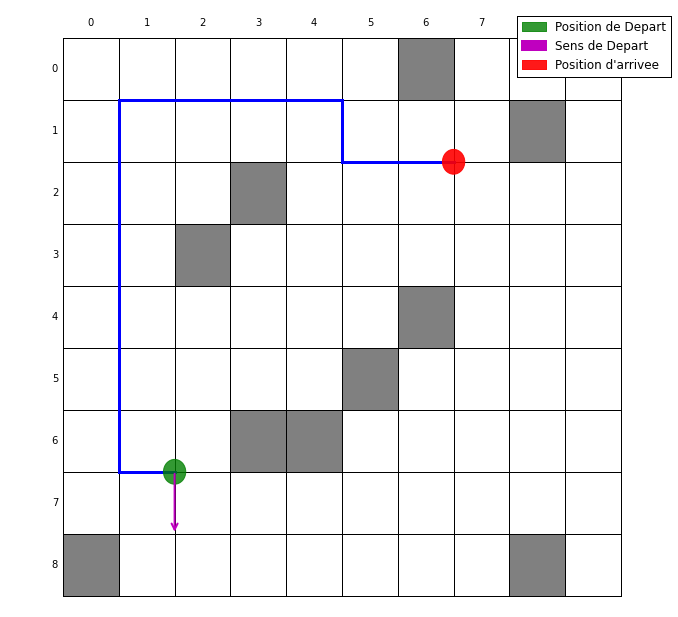

In [7]:
#lis le fichier entree.txt
M,N,A,start,end=p.read_entry_file('entree.txt')  

#genere le graphe
G=p.gen_graph(A)

#parcours en largeur et extraction de la solution optimale
result=p.gen_shortest_path(start,end,G)
print result[:-1]

#affiche le résultat
i=p.show_interface(result,A,start,end)

#ecris le resultat dans la fichier resultat.txt
p.write_result_file('resultat.txt','w',result[:2])

## Avec instance aléatoire

(21, ['a2', 'G', 'a2', 'D', 'a2', 'a3', 'a3', 'D', 'a2', 'a3', 'G', 'a3', 'a3', 'a3', 'a3', 'a3', 'G', 'a2', 'a3', 'G', 'a2'])


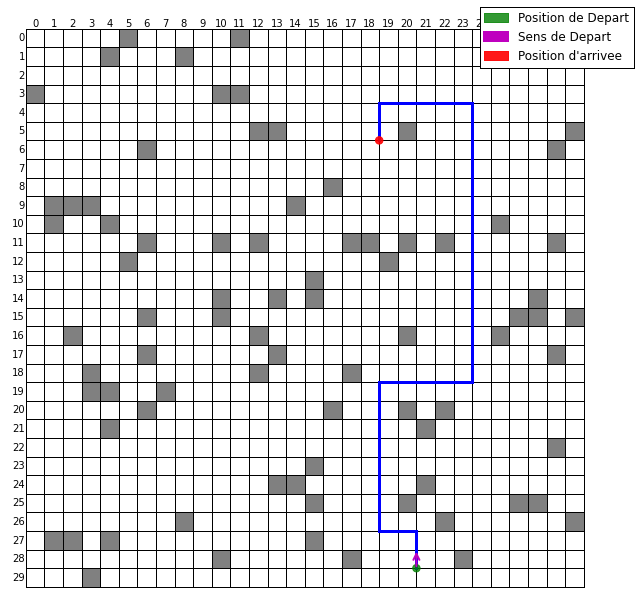

In [9]:
A2=p.gen_rand_instance(30,30,80)
G2=p.gen_graph(A2)
start2,end2=p.gen_rand_positions(G2)
result2=p.gen_shortest_path(start2,end2,G2)
print result2[:-1]
p.show_interface(result2,A2,start2,end2)
p.write_result_file('rand_resultat.txt','w',result2[:-1])

# Conclusion

En conclusion...